**I/ Data Processing**

In [40]:
import pandas as pd
import glob
import os
import matplotlib as plt

# Đường dẫn đến thư mục chứa các folder tuyến xe (thay đổi cho đúng máy bạn)
root_folder = r'D:\Data\BDC_30_routes_April_2025\HCMC_bus_routes'

# List chứa các dataframe tạm
all_stops_list = []

# Dùng glob để tìm tất cả các file csv trạm trong các thư mục con
# Tìm cả chiều đi (stops_by_var) và chiều về (rev_stops_by_var)
search_patterns = [
    os.path.join(root_folder, '*', 'stops_by_var.csv'),
    os.path.join(root_folder, '*', 'rev_stops_by_var.csv')
]

print("Đang tổng hợp dữ liệu các trạm...")

for pattern in search_patterns:
    for file_path in glob.glob(pattern):
        try:
            # Đọc file
            df = pd.read_csv(file_path)
            
            # Chỉ lấy các cột cần thiết (để nhẹ file và dễ gộp)
            # Dựa vào ảnh bạn gửi: StopId, Code, Lat, Lng, Name (nếu có)
            cols_to_keep = ['StopId', 'Code', 'Lat', 'Lng', 'Name']
            
            # Lọc chỉ lấy cột tồn tại trong file để tránh lỗi
            existing_cols = [c for c in cols_to_keep if c in df.columns]
            df = df[existing_cols]
            
            all_stops_list.append(df)
        except Exception as e:
            print(f"Lỗi đọc file {file_path}: {e}")

# Gộp tất cả lại
if all_stops_list:
    master_stops = pd.concat(all_stops_list, ignore_index=True)
    
    # === QUAN TRỌNG: LOẠI BỎ TRÙNG LẶP ===
    # Giữ lại dòng đầu tiên tìm thấy của mỗi StopId
    master_stops = master_stops.drop_duplicates(subset=['StopId'])
    
    # Lưu ra file CSV số 1
    master_stops.to_csv('master_unique_stops.csv', index=False)
    print(f"Đã tạo xong file 'master_unique_stops.csv' với {len(master_stops)} trạm duy nhất.")
else:
    print("Không tìm thấy file nào.")

Đang tổng hợp dữ liệu các trạm...
Đã tạo xong file 'master_unique_stops.csv' với 2136 trạm duy nhất.
Đã tạo xong file 'master_unique_stops.csv' với 2136 trạm duy nhất.


In [152]:
from sklearn.neighbors import BallTree
import numpy as np
import pandas as pd

# 1. Đọc dữ liệu
# File trạm chuẩn vừa tạo ở bước trên
root_folder = r'D:\Data\BDC_30_routes_April_2025\raw_GPS'
other_folder = r'D:\Data\BDC_30_routes_April_2025'
df_stops = pd.read_csv(f'{other_folder}/master_unique_stops.csv')
# File log GPS thô (thay tên file của bạn vào đây)
df_raw = pd.read_csv(f'{root_folder}/anonymized_raw_2025-04-01.csv')

print("Đang xử lý mapping...")

# 2. Chuẩn bị dữ liệu cho BallTree
# BallTree yêu cầu đầu vào là Radian (không phải Độ)
# Lưu ý: Ảnh bạn gửi file stops dùng 'Lat'/'Lng' (viết hoa), file raw dùng 'lat'/'lng' (thường)
stops_rad = np.radians(df_stops[['Lat', 'Lng']].values)
raw_rad = np.radians(df_raw[['lat', 'lng']].values)

# 3. Xây dựng cây tìm kiếm (BallTree) dựa trên các trạm chuẩn
# metric='haversine' để tính khoảng cách mặt cầu
tree = BallTree(stops_rad, metric='haversine')

# 4. Truy vấn tìm trạm gần nhất cho TẤT CẢ các điểm trong file Raw
# k=1 nghĩa là chỉ tìm 1 điểm gần nhất
distances, indices = tree.query(raw_rad, k=1)

# 5. Chuyển đổi khoảng cách từ Radian sang Mét
# Bán kính trái đất ~ 6371000 mét
distances_in_meters = distances * 6371000

# 6. Gán kết quả vào dataframe gốc
# Lấy StopId và tọa độ chuẩn tương ứng với index tìm được
df_raw['matched_stop_id'] = df_stops.iloc[indices.flatten()]['StopId'].values
df_raw['matched_lat'] = df_stops.iloc[indices.flatten()]['Lat'].values
df_raw['matched_lng'] = df_stops.iloc[indices.flatten()]['Lng'].values
df_raw['distance_diff_meters'] = distances_in_meters

# 7. Lọc theo ngưỡng sai số (Threshold)
# Chỉ map những điểm nào lệch dưới 20 mét (hoặc 30m tùy bạn chỉnh)
# Những điểm xa hơn coi như xe đang chạy trên đường, không phải ở trạm
THRESHOLD_METERS = 750 # Bạn có thể sửa số này

# Tạo file kết quả: Chỉ lấy những dòng khớp với trạm
matched_data = df_raw[df_raw['distance_diff_meters'] <= THRESHOLD_METERS].copy()

# Lưu file CSV thứ 2
matched_data.to_csv('mapped_gps_to_stops.csv', index=False)

print("Hoàn tất!")
print(f"Tìm thấy {len(matched_data)} điểm GPS khớp với trạm dừng (sai số <= {THRESHOLD_METERS}m).")
print("File kết quả: mapped_gps_to_stops.csv")

Đang xử lý mapping...
Hoàn tất!
Tìm thấy 2233842 điểm GPS khớp với trạm dừng (sai số <= 750m).
File kết quả: mapped_gps_to_stops.csv
Hoàn tất!
Tìm thấy 2233842 điểm GPS khớp với trạm dừng (sai số <= 750m).
File kết quả: mapped_gps_to_stops.csv


In [ ]:
# # LỌC CHỈ XE CHẠY TUYẾN 01
# # Xe phải đi qua ít nhất 50% số trạm của tuyến 01 mới được coi là xe tuyến 01

# MIN_COVERAGE = 0.5  # 50% số trạm

# stops_route_01 = set(df_bus_route['StopId'].unique())
# total_stops_route_01 = len(stops_route_01)

# print(f"Tuyến 01 có {total_stops_route_01} trạm")
# print(f"Ngưỡng lọc: Xe phải đi qua ít nhất {MIN_COVERAGE*100}% trạm ({int(total_stops_route_01*MIN_COVERAGE)} trạm)")
# print(f"\n{'='*80}\n")

# # Phân tích từng xe
# vehicle_coverage = df_matched.groupby('anonymized_vehicle')['matched_stop_id'].apply(set)

# route_01_vehicles = []
# other_vehicles = []

# for vehicle, stops_visited in vehicle_coverage.items():
#     num_matched = len(stops_visited & stops_route_01)
#     coverage = num_matched / total_stops_route_01
    
#     if coverage >= MIN_COVERAGE:
#         route_01_vehicles.append({
#             'vehicle': vehicle,
#             'stops_matched': num_matched,
#             'coverage': coverage * 100
#         })
#     else:
#         other_vehicles.append({
#             'vehicle': vehicle,
#             'stops_matched': num_matched,
#             'coverage': coverage * 100
#         })

# # Sắp xếp theo coverage
# route_01_vehicles.sort(key=lambda x: x['coverage'], reverse=True)
# other_vehicles.sort(key=lambda x: x['coverage'], reverse=True)

# print(f"✅ XE CHẠY TUYẾN 01: {len(route_01_vehicles)} xe")
# print(f"{'='*80}")
# for i, veh in enumerate(route_01_vehicles, 1):
#     print(f"{i}. {veh['vehicle']}: {veh['stops_matched']}/{total_stops_route_01} trạm ({veh['coverage']:.1f}%)")

# print(f"\n❌ XE KHÁC (không phải tuyến 01): {len(other_vehicles)} xe")
# print(f"{'='*80}")
# for i, veh in enumerate(other_vehicles[:10], 1):  # Chỉ hiển thị 10 xe đầu
#     print(f"{i}. {veh['vehicle']}: {veh['stops_matched']}/{total_stops_route_01} trạm ({veh['coverage']:.1f}%) - Có thể là tuyến khác")
# if len(other_vehicles) > 10:
#     print(f"... và {len(other_vehicles)-10} xe khác")

# # Tạo DataFrame chỉ chứa xe tuyến 01
# route_01_vehicle_ids = [v['vehicle'] for v in route_01_vehicles]
# df_gps_route_01_only = df_matched[df_matched['anonymized_vehicle'].isin(route_01_vehicle_ids)]

# print(f"\n{'='*80}")
# print(f"TỔNG KẾT:")
# print(f"  - Tổng xe trong df_gps_on_route: {len(vehicle_coverage)}")
# print(f"  - Xe thuộc tuyến 01: {len(route_01_vehicles)}")
# print(f"  - Xe tuyến khác: {len(other_vehicles)}")
# print(f"  - Số dòng sau khi lọc: {len(df_gps_route_01_only)}")
# print(f"{'='*80}")

Tuyến 01 có 28 trạm
Ngưỡng lọc: Xe phải đi qua ít nhất 50.0% trạm (14 trạm)


✅ XE CHẠY TUYẾN 01: 7 xe
1. 311b570f60: 28/28 trạm (100.0%)
2. 4d38c30a62: 28/28 trạm (100.0%)
3. 6dc5d7541d: 28/28 trạm (100.0%)
4. a3b5018cb3: 28/28 trạm (100.0%)
5. b7312427d3: 28/28 trạm (100.0%)
6. f79f1e1415: 28/28 trạm (100.0%)
7. 6adc3d9231: 27/28 trạm (96.4%)

❌ XE KHÁC (không phải tuyến 01): 447 xe
1. 001d86aa2e: 6/28 trạm (21.4%) - Có thể là tuyến khác
2. 04cb163a00: 6/28 trạm (21.4%) - Có thể là tuyến khác
3. 10f7ac8e21: 6/28 trạm (21.4%) - Có thể là tuyến khác
4. 477da3735a: 6/28 trạm (21.4%) - Có thể là tuyến khác
5. 92b20613bc: 6/28 trạm (21.4%) - Có thể là tuyến khác
6. c0c468f719: 6/28 trạm (21.4%) - Có thể là tuyến khác
7. fe32c51268: 6/28 trạm (21.4%) - Có thể là tuyến khác
8. 34432a8f74: 5/28 trạm (17.9%) - Có thể là tuyến khác
9. 3bf699d6c1: 5/28 trạm (17.9%) - Có thể là tuyến khác
10. 4a05ddf554: 5/28 trạm (17.9%) - Có thể là tuyến khác
... và 437 xe khác

TỔNG KẾT:
  - Tổng xe trong df_

In [ ]:
df_gps = pd.read_csv(r'D:\Data\BDC_30_routes_April_2025\raw_GPS\anonymized_raw_2025-04-01.csv')
df_bus_route = pd.read_csv(r'D:\Data\BDC_30_routes_April_2025\HCMC_bus_routes\1\stops_by_var.csv')
df_matched = pd.read_csv(r'D:\Data\BDC_30_routes_April_2025\mapped_gps_to_stops.csv')
df_matched['datetime'] = pd.to_datetime(df_matched['datetime'])

df_matched = df_matched[
    df_matched['datetime'].dt.time.between(
        pd.to_datetime("04:30").time(), 
        pd.to_datetime("06:59").time()
    )
]

df_matched = df_matched[['matched_stop_id', 'anonymized_vehicle']]
df_matched.drop_duplicates(inplace=True)


In [188]:
import os

folder_path = r"D:\Data\BDC_30_routes_April_2025\HCMC_bus_routes"

folders = [
    name for name in os.listdir(folder_path)
    if os.path.isdir(os.path.join(folder_path, name))
]

print(f"Danh sách các tuyến xe trong HCMC_bus_routes:")
print(f"Tổng số tuyến: {len(folders)}\n")
print(sorted(folders, key=lambda x: int(x) if x.isdigit() else float('inf')))

Danh sách các tuyến xe trong HCMC_bus_routes:
Tổng số tuyến: 30

['1', '4', '6', '9', '20', '29', '41', '44', '47', '57', '61', '62', '65', '69', '72', '73', '74', '76', '81', '84', '88', '93', '99', '102', '103', '141', '146', '151', '153', '161']


In [ ]:
# ĐÁNH LABEL ROUTE CHO ĐỮ LIỆU GPS

import pandas as pd

# Đọc dữ liệu GPS đã matched
df_gps_labeled = pd.read_csv(r'D:\Data\BDC_30_routes_April_2025\mapped_gps_to_stops.csv')
df_gps_labeled['datetime'] = pd.to_datetime(df_gps_labeled['datetime'])

# Lọc thời gian 4:30 - 7:00
df_gps_labeled = df_gps_labeled[
    df_gps_labeled['datetime'].dt.time.between(
        pd.to_datetime("04:30").time(), 
        pd.to_datetime("06:59").time()
    )
]

# Khởi tạo cột Route (mặc định là Unknown)
df_gps_labeled['Route'] = 'Unknown'

# Danh sách các tuyến cần kiểm tra
routes_to_check = folders
MIN_COVERAGE = 0.8  

print(f"Bắt đầu đánh label cho {len(df_gps_labeled)} điểm GPS...")
print(f"Ngưỡng matching: {MIN_COVERAGE*100}%\n")
print(f"{'='*80}\n")

# Dictionary lưu kết quả
vehicle_route_mapping = {}

for route_id in routes_to_check:
    print(f"Đang xử lý tuyến {route_id}...")
    
    # Đọc danh sách trạm của tuyến
    try:
        df_route_stops = pd.read_csv(
            f'D:\\Data\\BDC_30_routes_April_2025\\HCMC_bus_routes\\{route_id}\\stops_by_var.csv'
        )
        stops_route = set(df_route_stops['StopId'].unique())
        total_stops = len(stops_route)
        
        print(f"  - Tuyến {route_id} có {total_stops} trạm")
        
        # Nhóm theo xe và tính matching
        vehicle_stops = df_gps_labeled.groupby('anonymized_vehicle')['matched_stop_id'].apply(set)
        
        matched_vehicles = []
        for vehicle, stops_visited in vehicle_stops.items():
            num_matched = len(stops_visited & stops_route)
            coverage = num_matched / total_stops
            
            if coverage >= MIN_COVERAGE:
                matched_vehicles.append(vehicle)
                # Lưu mapping (xe có thể thuộc nhiều tuyến nếu >90%)
                if vehicle not in vehicle_route_mapping:
                    vehicle_route_mapping[vehicle] = []
                vehicle_route_mapping[vehicle].append({
                    'route': route_id,
                    'coverage': coverage * 100,
                    'matched': num_matched,
                    'total': total_stops
                })
        
        print(f"  - Tìm thấy {len(matched_vehicles)} xe khớp > {MIN_COVERAGE*100}%")
        
    except FileNotFoundError:
        print(f"  ⚠️ Không tìm thấy file cho tuyến {route_id}")
        continue

print(f"\n{'='*80}")
print(f"KẾT QUẢ MAPPING:\n")

# Gán label cho từng xe
for vehicle, routes_info in vehicle_route_mapping.items():
    if len(routes_info) == 1:
        # Xe chỉ thuộc 1 tuyến
        route_label = routes_info[0]['route']
        print(f"Xe {vehicle}: Tuyến {route_label} ({routes_info[0]['coverage']:.1f}%)")
    else:
        # Xe thuộc nhiều tuyến - chọn tuyến có coverage cao nhất
        best_route = max(routes_info, key=lambda x: x['coverage'])
        route_label = best_route['route']
        print(f"Xe {vehicle}: Tuyến {route_label} ({best_route['coverage']:.1f}%) - Cũng khớp: {[r['route'] for r in routes_info if r['route'] != route_label]}")
    
    # Gán label vào dataframe
    df_gps_labeled.loc[
        df_gps_labeled['anonymized_vehicle'] == vehicle, 
        'Route'
    ] = f"Route_{route_label}"

# Thống kê kết quả
print(f"\n{'='*80}")
print(f"THỐNG KÊ LABEL:\n")
print(df_gps_labeled['Route'].value_counts())


Bắt đầu đánh label cho 267497 điểm GPS...
Ngưỡng matching: 80.0%


Đang xử lý tuyến 1...
  - Tuyến 1 có 28 trạm
  - Tìm thấy 7 xe khớp > 80.0%
Đang xử lý tuyến 102...
  - Tuyến 102 có 61 trạm
  - Tìm thấy 10 xe khớp > 80.0%
Đang xử lý tuyến 103...
  - Tuyến 103 có 62 trạm
  - Tìm thấy 8 xe khớp > 80.0%
Đang xử lý tuyến 141...
  - Tuyến 141 có 47 trạm
  - Tìm thấy 13 xe khớp > 80.0%
Đang xử lý tuyến 146...
  - Tuyến 146 có 44 trạm
  - Tìm thấy 11 xe khớp > 80.0%
Đang xử lý tuyến 151...
  - Tuyến 151 có 39 trạm
  - Tìm thấy 8 xe khớp > 80.0%
Đang xử lý tuyến 141...
  - Tuyến 141 có 47 trạm
  - Tìm thấy 13 xe khớp > 80.0%
Đang xử lý tuyến 146...
  - Tuyến 146 có 44 trạm
  - Tìm thấy 11 xe khớp > 80.0%
Đang xử lý tuyến 151...
  - Tuyến 151 có 39 trạm
  - Tìm thấy 16 xe khớp > 80.0%
Đang xử lý tuyến 153...
  - Tuyến 153 có 29 trạm
  - Tìm thấy 11 xe khớp > 80.0%
Đang xử lý tuyến 161...
  - Tuyến 161 có 37 trạm
  - Tìm thấy 13 xe khớp > 80.0%
Đang xử lý tuyến 20...
  - Tuyến 20 có 52 trạm
  

In [ ]:
output_file = 'mapped_gps_with_route_labels.csv'
df_gps_labeled.to_csv(output_file, index=False)
print(f"\n{'='*80}")
print(f"Đã lưu kết quả vào: {output_file}")
print(f"Tổng số dòng: {len(df_gps_labeled)}")
print(f"Số xe đã được gán label: {len(vehicle_route_mapping)}")
print(f"Số xe chưa xác định: {(df_gps_labeled['Route'] == 'Unknown').sum()}")


Đã lưu kết quả vào: mapped_gps_with_route_labels.csv
Tổng số dòng: 267497
Số xe đã được gán label: 326
Số xe chưa xác định: 58430


In [198]:
df_gps_route = df_gps_labeled[[ 'anonymized_vehicle', 'datetime','matched_stop_id','Route']]
df_gps_route = df_gps_route[df_gps_route['Route'] != 'Unknown']

**II/ EDA**

In [203]:
# THỐNG KÊ CÁC TUYẾN QUA MỖI TRẠM

import pandas as pd
import os
import glob

root_folder = r'D:\Data\BDC_30_routes_April_2025\HCMC_bus_routes'

# Dictionary để lưu: stop_id -> list các tuyến đi qua
stop_route_mapping = {}

print("Đang thống kê các tuyến đi qua mỗi trạm...\n")

# Đọc master_unique_stops để lấy thông tin Name
df_master_stops = pd.read_csv(r'D:\Data\BDC_30_routes_April_2025\master_unique_stops.csv')
stop_name_dict = dict(zip(df_master_stops['StopId'], df_master_stops['Name']))

# Duyệt qua tất cả các folder tuyến
for folder_name in sorted(os.listdir(root_folder), key=lambda x: int(x) if x.isdigit() else float('inf')):
    folder_path = os.path.join(root_folder, folder_name)
    
    if not os.path.isdir(folder_path):
        continue
    
    # Đọc file stops_by_var.csv
    stops_file = os.path.join(folder_path, 'stops_by_var.csv')
    
    if os.path.exists(stops_file):
        try:
            df_stops = pd.read_csv(stops_file)
            
            # Lấy danh sách StopId trong tuyến này
            stop_ids = df_stops['StopId'].unique()
            
            # Thêm tuyến này vào mỗi trạm
            for stop_id in stop_ids:
                if stop_id not in stop_route_mapping:
                    stop_route_mapping[stop_id] = []
                stop_route_mapping[stop_id].append(folder_name)
                
            print(f"Tuyến {folder_name}: {len(stop_ids)} trạm")
            
        except Exception as e:
            print(f"⚠️ Lỗi đọc tuyến {folder_name}: {e}")

# Tạo DataFrame từ kết quả
stop_route_data = []
for stop_id, routes in stop_route_mapping.items():
    stop_route_data.append({
        'StopId': stop_id,
        'Name': stop_name_dict.get(stop_id, 'Unknown'),
        'Số_tuyến_qua': len(routes),
        'Danh_sách_tuyến': ', '.join(sorted(routes, key=lambda x: int(x) if x.isdigit() else float('inf')))
    })

df_stop_routes = pd.DataFrame(stop_route_data)
df_stop_routes = df_stop_routes.sort_values('Số_tuyến_qua', ascending=False)

# Lưu kết quả
output_file = 'stop_route_statistics.csv'
df_stop_routes.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"\n{'='*80}")
print(f"THỐNG KÊ:")
print(f"  - Tổng số trạm: {len(df_stop_routes)}")
print(f"  - Trạm có nhiều tuyến nhất: {df_stop_routes.iloc[0]['Số_tuyến_qua']} tuyến")

print(f"  - Trạm có ít tuyến nhất: {df_stop_routes.iloc[-1]['Số_tuyến_qua']} tuyến")
print(f"Đã lưu kết quả vào: {output_file}")

print(f"\nTop 10 trạm có nhiều tuyến qua nhất:")
print(f"\n{'='*80}")
print(df_stop_routes.head(10).to_string(index=False))

Đang thống kê các tuyến đi qua mỗi trạm...

Tuyến 1: 28 trạm
Tuyến 4: 47 trạm
Tuyến 6: 52 trạm
Tuyến 9: 60 trạm
Tuyến 20: 52 trạm
Tuyến 29: 47 trạm
Tuyến 41: 56 trạm
Tuyến 44: 43 trạm
Tuyến 47: 37 trạm
Tuyến 57: 34 trạm
Tuyến 61: 42 trạm
Tuyến 62: 60 trạm
Tuyến 65: 44 trạm
Tuyến 69: 74 trạm
Tuyến 72: 42 trạm
Tuyến 73: 46 trạm
Tuyến 74: 41 trạm
Tuyến 76: 44 trạm
Tuyến 81: 49 trạm
Tuyến 84: 38 trạm
Tuyến 88: 55 trạm
Tuyến 93: 55 trạm
Tuyến 99: 52 trạm
Tuyến 102: 61 trạm
Tuyến 103: 62 trạm
Tuyến 141: 47 trạm
Tuyến 146: 44 trạm
Tuyến 151: 39 trạm
Tuyến 153: 29 trạm
Tuyến 161: 37 trạm

THỐNG KÊ:
  - Tổng số trạm: 1170
  - Trạm có nhiều tuyến nhất: 8 tuyến
  - Trạm có ít tuyến nhất: 1 tuyến
Đã lưu kết quả vào: stop_route_statistics.csv

Top 10 trạm có nhiều tuyến qua nhất:

 StopId                     Name  Số_tuyến_qua                Danh_sách_tuyến
   7276            Tôn Thất Tùng             8 4, 20, 65, 69, 72, 88, 93, 102
     35      Bến xe buýt Sài Gòn             8 4, 20, 65, 69, 72,

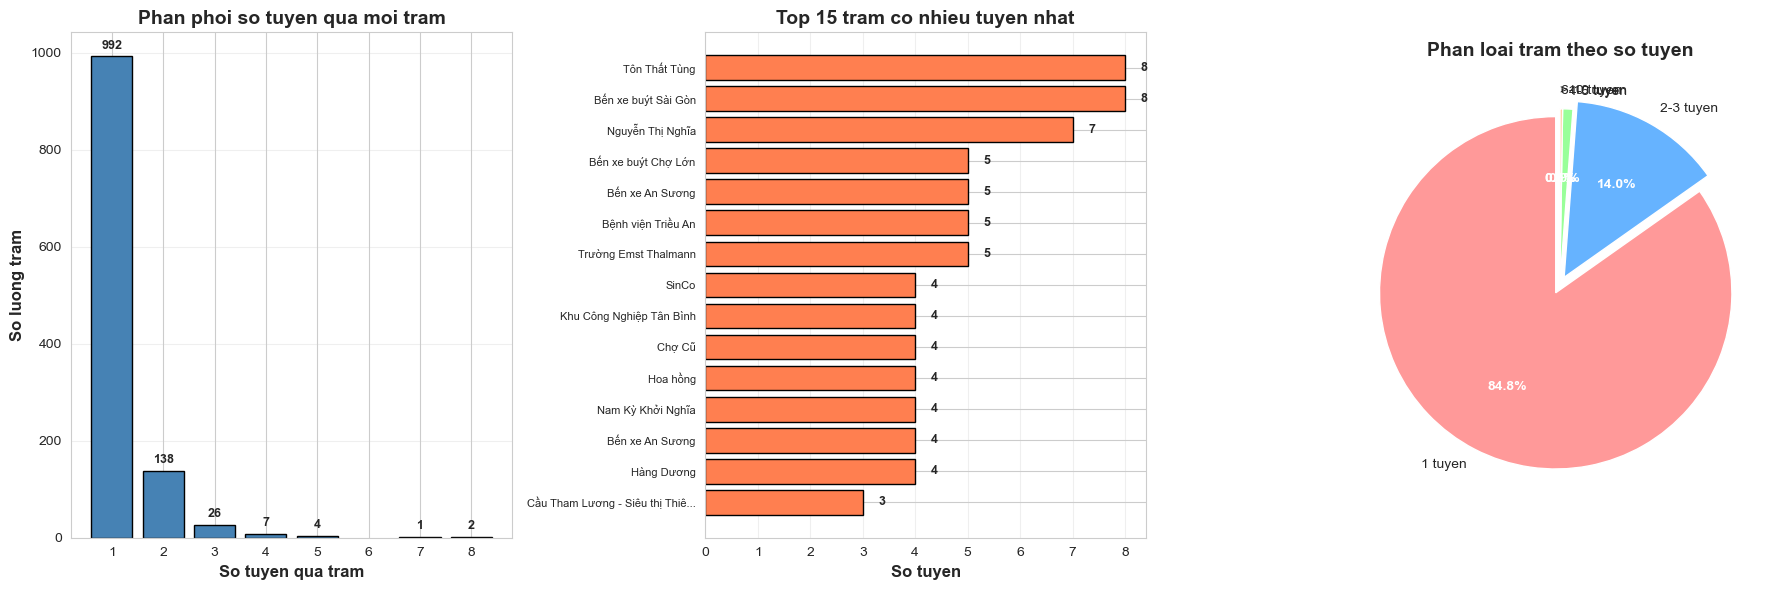

Đã lưu biểu đồ: stop_route_statistics.png


In [211]:
# VẼ BIỂU ĐỒ THỐNG KÊ SỐ TUYẾN QUA MỖI TRẠM

import matplotlib.pyplot as plt
import seaborn as sns

# Thiết lập style
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")

# Đọc dữ liệu nếu chưa có
if 'df_stop_routes' not in locals():
    df_stop_routes = pd.read_csv('stop_route_statistics.csv')

# 1. Biểu đồ phân phối số tuyến qua trạm (Histogram)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Subplot 1: Histogram - Phân phối số tuyến
ax1 = axes[0]
counts = df_stop_routes['Số_tuyến_qua'].value_counts().sort_index()
ax1.bar(counts.index, counts.values, color='steelblue', edgecolor='black')
ax1.set_xlabel('So tuyen qua tram', fontsize=12, fontweight='bold')
ax1.set_ylabel('So luong tram', fontsize=12, fontweight='bold')
ax1.set_title('Phan phoi so tuyen qua moi tram', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Thêm annotation cho các cột
for i, (num_routes, count) in enumerate(counts.items()):
    ax1.text(num_routes, count + max(counts.values)*0.01, str(count), 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# Subplot 2: Top 15 trạm có nhiều tuyến nhất
ax2 = axes[1]
top_15 = df_stop_routes.head(15)
bars = ax2.barh(range(len(top_15)), top_15['Số_tuyến_qua'], color='coral', edgecolor='black')
ax2.set_yticks(range(len(top_15)))
# Sử dụng Name thay vì StopId, cắt ngắn nếu tên quá dài
stop_labels = [name[:30] + '...' if len(str(name)) > 30 else str(name) for name in top_15['Name']]
ax2.set_yticklabels(stop_labels, fontsize=8)
ax2.set_xlabel('So tuyen', fontsize=12, fontweight='bold')
ax2.set_title('Top 15 tram co nhieu tuyen nhat', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# Thêm giá trị vào các thanh
for i, (idx, row) in enumerate(top_15.iterrows()):
    ax2.text(row['Số_tuyến_qua'] + 0.3, i, str(row['Số_tuyến_qua']), 
             va='center', fontsize=9, fontweight='bold')

# Subplot 3: Pie Chart - Phân loại trạm theo số tuyến
ax3 = axes[2]
bins = [0, 1, 3, 5, 10, 100]
labels = ['1 tuyen', '2-3 tuyen', '4-5 tuyen', '6-10 tuyen', '>10 tuyen']
df_stop_routes['Nhom'] = pd.cut(df_stop_routes['Số_tuyến_qua'], bins=bins, labels=labels, include_lowest=True)
category_counts = df_stop_routes['Nhom'].value_counts()

colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc']
wedges, texts, autotexts = ax3.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%',
                                     colors=colors, startangle=90, textprops={'fontsize': 10},
                                     explode=[0.05, 0.05, 0, 0, 0])  # Tách các phần ra
ax3.set_title('Phan loai tram theo so tuyen', fontsize=14, fontweight='bold')

# Làm đậm % trên pie chart
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.savefig('stop_route_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

print("Đã lưu biểu đồ: stop_route_statistics.png")

In [212]:
# PHÂN TÍCH TUYẾN CHẠY QUÁ TỐC ĐỘ TRUNG BÌNH

import pandas as pd

# Đọc dữ liệu long_trips_report
df_long_trips = pd.read_csv(r'D:\Data\BDC_30_routes_April_2025\long_trips_report.csv')

# Đổi tên cột vehicle thành anonymized_vehicle để dễ merge
df_long_trips.rename(columns={'vehicle': 'anonymized_vehicle'}, inplace=True)

# Merge với df_gps_route để lấy thông tin Route
df_speed_analysis = df_long_trips.merge(
    df_gps_route[['anonymized_vehicle', 'Route']].drop_duplicates(),
    on='anonymized_vehicle',
    how='inner'
)

# Thống kê tốc độ theo tuyến
route_speed_stats = df_speed_analysis.groupby('Route').agg({
    'avg_minutes': ['mean', 'median', 'std', 'min', 'max', 'count'],
    'duration_seconds': ['mean', 'median']
}).round(2)

# Làm phẳng MultiIndex columns
route_speed_stats.columns = ['_'.join(col).strip() for col in route_speed_stats.columns]
route_speed_stats = route_speed_stats.reset_index()

# Sắp xếp theo avg_minutes_mean giảm dần (tuyến nào avg_minutes cao = chạy chậm hơn)
route_speed_stats = route_speed_stats.sort_values('avg_minutes_mean', ascending=False)

print(f"{'='*100}")
print(f"THỐNG KÊ TỐC ĐỘ TRUNG BÌNH THEO TUYẾN")
print(f"{'='*100}\n")
print(route_speed_stats.to_string(index=False))

# Lưu kết quả
route_speed_stats.to_csv('route_speed_statistics.csv', index=False)
print(f"\n{'='*100}")
print(f"Đã lưu kết quả vào: route_speed_statistics.csv")

THỐNG KÊ TỐC ĐỘ TRUNG BÌNH THEO TUYẾN

    Route  avg_minutes_mean  avg_minutes_median  avg_minutes_std  avg_minutes_min  avg_minutes_max  avg_minutes_count  duration_seconds_mean  duration_seconds_median
 Route_69            273.12              278.16            32.98           232.07           311.90                 41               43540.98                  42420.0
 Route_88            244.51              260.10            30.31           203.69           293.41                146               50015.75                  40830.0
 Route_99            214.29              201.10            59.75           189.50           605.58                234               36532.05                  35760.0
 Route_57            189.98              189.91            22.90           166.18           244.14                219               32262.74                  37140.0
Route_153            179.38              174.49            14.99           160.93           230.41                148              

In [199]:
df_gps_route

,anonymized_vehicle,datetime,matched_stop_id,Route
162041,a705f03b37,2025-04-01 04:30:03,8,Route_81
162088,510421fb55,2025-04-01 04:30:03,3905,Route_81
162099,769e6b3cec,2025-04-01 04:30:05,3897,Route_81
162100,d8017ac9dd,2025-04-01 04:30:00,834,Route_20
162113,3781acf31d,2025-04-01 04:30:07,2783,Route_44
...,...,...,...,...
441598,0bca6f08c6,2025-04-01 06:52:43,732,Route_74
441621,0bca6f08c6,2025-04-01 06:51:10,732,Route_74
441724,0bca6f08c6,2025-04-01 06:51:21,732,Route_74
441752,0bca6f08c6,2025-04-01 06:52:27,732,Route_74


KeyError: 'Route'

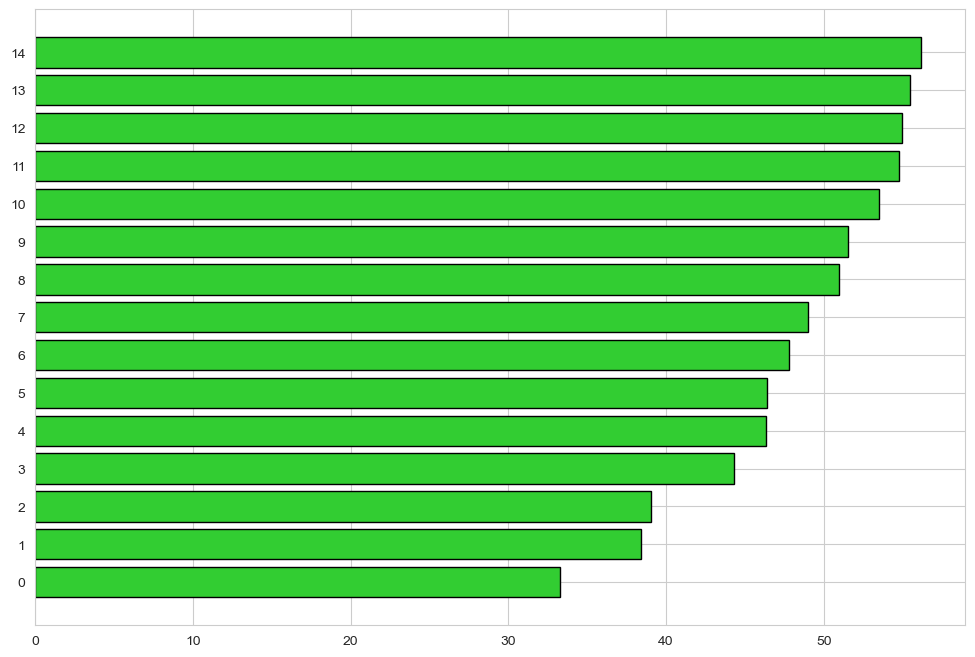

In [ ]:
# VẼ BIỂU ĐỒ TOP 15 XE CHẠY NHANH NHẤT

import matplotlib.pyplot as plt
import seaborn as sns

# Thiết lập style
sns.set_style("whitegrid")

# Thống kê theo xe (vehicle) và lấy Route
vehicle_speed_stats = df_speed_analysis.groupby('anonymized_vehicle').agg({
    'avg_minutes': ['mean', 'median', 'std', 'count']
}).round(2)

# Làm phẳng MultiIndex columns
vehicle_speed_stats.columns = ['_'.join(col).strip() for col in vehicle_speed_stats.columns]
vehicle_speed_stats = vehicle_speed_stats.reset_index()

# Thêm thông tin Route cho mỗi xe
vehicle_route_map = df_speed_analysis.groupby('anonymized_vehicle')['Route'].first().to_dict()
vehicle_speed_stats['Route'] = vehicle_speed_stats['anonymized_vehicle'].map(vehicle_route_map)

# Tạo figure với 1 subplot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Top 15 xe chạy nhanh nhất (avg_minutes thấp nhất)
top_15_fastest = vehicle_speed_stats.sort_values('avg_minutes_mean', ascending=True).head(15)

bars = ax.barh(range(len(top_15_fastest)), top_15_fastest['avg_minutes_mean'], color='limegreen', edgecolor='black')
ax.set_yticks(range(len(top_15_fastest)))

# Hiển thị vehicle ID + Route
labels = [f"{row['anonymized_vehicle'][:10]}... ({row['Route']})" for idx, row in top_15_fastest.iterrows()]
ax.set_yticklabels(labels, fontsize=9)
ax.set_xlabel('Thoi gian trung binh (phut)', fontsize=12, fontweight='bold')
ax.set_title('Top 15 xe chay nhanh nhat', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Thêm giá trị
for i, (idx, row) in enumerate(top_15_fastest.iterrows()):
    ax.text(row['avg_minutes_mean'] + 2, i, f"{row['avg_minutes_mean']:.1f}", 
            va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('vehicle_speed_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Da luu bieu do: vehicle_speed_analysis.png")